# Logistic Regression Model Notebook

```md
@authors: miguelrocha and Grupo 03
```

In [9]:
# Notebook Imports
import numpy as np

from models.logistic_regression_model import LogisticRegression, hyperparameter_tuning
from helpers.dataset import Dataset
from helpers.model import save_model
from helpers.metrics import confusion_matrix, balanced_accuracy, precision_recall_f1
from helpers.enums import ModelRunMode

In [10]:
# Model run mode
# Options: 
#   ModelRunMode.TRAIN.value            (Train the model)
#   ModelRunMode.CLASSIFY.value         (Classify data)
mode = ModelRunMode.TRAIN.value
# Prefix for saving the model files
model_prefix = "logistical_regression_model_1"

In [11]:
# Parameters configuration
if mode == ModelRunMode.TRAIN.value:
    # TRAIN mode: Set parameters for training
    input_csv = "../tarefa_1/test_input_dataset/merged_inputs.csv"                      # CSV file with training inputs (ID, Text)
    output_csv = "../tarefa_1/test_output_dataset/merged_outputs.csv"                   # CSV file with training outputs (ID, Label)
    test_size = 0.3                                                                     # Proportion of the dataset reserved as test data
    validation_size = 0.2                                                               # Proportion of the dataset reserved as validation data (used during hyperparameter tuning)
    regularization = True                                                               # Flag to enable L2 regularization during training
    random_state=42                                                                     # Seed for reproducible dataset splitting
    max_vocab_size=None                                                                 # Maximum vocabulary size (None implies no limit)
    min_freq=1                                                                          # Minimum frequency required for a word to be included in the vocabulary
elif mode == ModelRunMode.CLASSIFY.value:
    # CLASSIFY mode: Set parameters for classification
    input_csv = "../tarefa_2/classify_input_datasets/submission3_inputs.csv"               # CSV file with texts for prediction (ID, Text)
    output_csv = "../tarefa_2/classify_output_datasets/submission3_outputs_lr_model.csv"   # CSV file to store prediction results
else:
    # Handle invalid mode selection
    print("The selected option is not valid. Options: \"train\" or \"classify\"!")
    SystemExit()

Train set has 1319 rows and 9350 columns
Test set has 565 rows and 9350 columns

Starting hyperparameter tuning...
Iter=0, cost=0.6931429322
Iter=1000, cost=0.6889508110
Iter=2000, cost=0.6848095742
Iter=3000, cost=0.6807104020
Iter=4000, cost=0.6766527816
alpha: 0.01, lamda: 0.01, iters: 5000 -> Validation Accuracy: 0.9432
Iter=0, cost=0.6931429322
Iter=1000, cost=0.6889543732
Iter=2000, cost=0.6848237136
Iter=3000, cost=0.6807419798
Iter=4000, cost=0.6767085074
alpha: 0.01, lamda: 0.1, iters: 5000 -> Validation Accuracy: 0.9432
Iter=0, cost=0.6931429322
Iter=1000, cost=0.6889897732
Iter=2000, cost=0.6849633574
Iter=3000, cost=0.6810519281
Iter=4000, cost=0.6772521203
alpha: 0.01, lamda: 1.0, iters: 5000 -> Validation Accuracy: 0.9432
Iter=0, cost=0.6931047049
Iter=1000, cost=0.6531192661
Iter=2000, cost=0.6169868672
Iter=3000, cost=0.5842815774
Iter=4000, cost=0.5546227897
alpha: 0.1, lamda: 0.01, iters: 5000 -> Validation Accuracy: 0.9583
Iter=0, cost=0.6931047051
Iter=1000, cost=0.

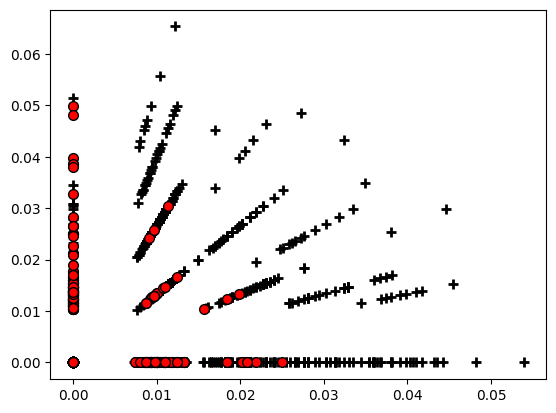

In [12]:
if mode == ModelRunMode.TRAIN.value:
    # Load datasets using TF-IDF vectorization
    X_train, y_train, X_test, y_test, vocab, idf = Dataset.prepare_train_test_tfidf(input_csv=input_csv, output_csv=output_csv, test_size=test_size, random_state=random_state, max_vocab_size=max_vocab_size, min_freq=min_freq)

    # Create Dataset objects for training and test data
    train_ds_full = Dataset(X=X_train, Y=y_train)
    test_ds = Dataset(X=X_test, Y=y_test)

    # Display dimensions of the training and test datasets
    print(f"Train set has {train_ds_full.nrows()} rows and {train_ds_full.ncols()} columns")
    print(f"Test set has {test_ds.nrows()} rows and {test_ds.ncols()} columns\n")

    # Split the full training dataset into training and validation subsets (80% training, 20% validation)
    n_train = train_ds_full.X.shape[0]
    indices = np.arange(n_train)
    np.random.shuffle(indices)
    split_idx = int((1 - validation_size) * n_train)
    train_idx = indices[:split_idx]
    val_idx = indices[split_idx:]
    train_ds = Dataset(X=train_ds_full.X[train_idx], Y=train_ds_full.Y[train_idx])
    val_ds = Dataset(X=train_ds_full.X[val_idx], Y=train_ds_full.Y[val_idx])

    # Define hyperparameter grids for tuning
    alphas = [0.01, 0.1]
    lambdas = [0.01, 0.1, 1.0]
    iters_list = [5000]

    # Perform hyperparameter tuning using the training and validation sets
    print("Starting hyperparameter tuning...")
    best_params, best_acc, results = hyperparameter_tuning(train_ds, val_ds, alphas, lambdas, iters_list)
    print("\nBest hyperparameters:", best_params)
    print("Best validation accuracy:", best_acc)

    # Retrain logistic regression model on the full training data using the best hyperparameters
    final_model = LogisticRegression(train_ds_full, regularization=(best_params["lamda"] > 0), lamda=best_params["lamda"])
    final_model.gradientDescent(alpha=best_params["alpha"], iters=best_params["iters"])

    # Alternative model training using cost function-based approach
    # final_model = LogisticRegression(train_ds_full, regularization=True, lamda=0.01)
    # final_model.buildModel()  

    # Save the trained model parameters along with the vocabulary and IDF values
    save_model(final_model.theta, vocab, idf, model_prefix)
    print(f"Model saved with prefix {model_prefix}")

    # Evaluate the final model on the test set
    ones_test = np.ones((test_ds.X.shape[0], 1))
    X_test_bias = np.hstack((ones_test, test_ds.X))
    test_acc = final_model.accuracy(X_test_bias, test_ds.Y)
    print(f"\nTest accuracy with best hyperparameters: {test_acc:.4f}")

    preds = final_model.predictMany(X_test_bias)
    TP, FP, TN, FN = confusion_matrix(y_test, preds)
    prec, rec, f1 = precision_recall_f1(y_test, preds)
    bal_acc = balanced_accuracy(y_test, preds)

    print("Confusion Matrix: TP={}, FP={}, TN={}, FN={}".format(TP, FP, TN, FN))
    print("Precision = {:.4f}, Recall = {:.4f}, F1 = {:.4f}".format(prec, rec, f1))
    print("Balanced Accuracy = {:.4f}".format(bal_acc))
    final_model.plotModel()

if mode == ModelRunMode.CLASSIFY.value:
    # Classify new texts using the saved model
    Dataset.classify_texts(input_csv, output_csv, model_prefix=model_prefix)